# Database Initialization

In [1]:
from __future__ import division
db = 'twitterGender'
import sqlalchemy
from sqlalchemy import create_engine
from sqlalchemy.engine.url import URL
myDB = URL(drivername='mysql', database=db, query={ 'read_default_file' : '/home/fatal/.my.cnf' })
engine = create_engine(name_or_url=myDB, encoding='utf8')
#conn = engine.connect()


# Necessary Libraries & Global Variables

In [22]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy.interpolate import UnivariateSpline

import time
import pdb

epsilon = 0.0000001
SMALL_VAL = 1
Zero = 0
RAND_COUNT = 5000
group_id_cnt = 0

In [45]:
def get_emp_pdf(data):
    normed_data = (data - np.mean(data)) / np.std(data)
    N = len(normed_data)
    hist_bins = int(N/10)
    p, x = np.histogram(normed_data, bins=hist_bins, normed=True) # bin it into n = N/10 bins
    x = x[:-1] + (x[1] - x[0])/2   # convert bin edges to centers
    #f = UnivariateSpline(x, p, s=hist_bins)
    return (x, p)

In [43]:
def fetch_data(table_name, feat, feat_total_cnt, feat_needed_cnt, use_random=True):
    if use_random and group_id_cnt > RAND_COUNT:
        fetch_data_query = "select * from {0} join \
        (select ceil(rand()*{3}) as id from {0} where feat='{1}') as r2 using(id) limit {2}" \
        .format(table_name, feat, feat_needed_cnt, feat_total_cnt)
    else:
        fetch_data_query = "select * from {0} where feat = '{1}'" \
        .format(table_name, feat)
    raw_df = pd.read_sql(fetch_data_query, con=engine)
    return raw_df
    
    
def prepare_data(table_name, feat, feat_total_cnt, feat_needed_cnt, include_zero=True, use_random=True):
    raw_df = fetch_data(table_name, feat, feat_total_cnt, feat_needed_cnt, use_random)
    data = raw_df.group_norm.tolist()
    total_cnt = group_id_cnt
    if use_random and total_cnt > RAND_COUNT:
        total_cnt = RAND_COUNT
    nonExisting_cnt = max(0, int(total_cnt - len(data)))
    # Appending zero for those that does not use this feature at all
    # By removing this line you can find the best 
    if include_zero:
        data = data + ([Zero]*nonExisting_cnt)
    return np.sort(data).tolist()

def plot_features_pdf(table_name, title, include_zero=True, use_random=True):
    pval_threshold = 0.05
    cntr = 1
    usr_best_fit = []
    query_time = 0
    fit_time = 0

    # Load DATA from DB
    stime = time.time()
    global group_id_cnt
    #pdb.set_trace()
    group_id_cnt = pd.read_sql('select count(distinct group_id) cnt from ' + table_name, con=engine)
    group_id_cnt = group_id_cnt.cnt[0]
    print(str(group_id_cnt) + ' data points for each feature')
    print(str(RAND_COUNT) + ' random data points will be selected instead, if it is smaller')
    # Load distinct features
    features = pd.read_sql('select feat, count(*) cnt from ' + table_name + ' group by feat', con=engine)
    feat_cnt = len(features)
    sample_frac = min(10/feat_cnt, 1)
    sample_features = features.sample(frac=sample_frac).reset_index(drop=True)
    print(str(feat_cnt) + ' unique features' )
        
    if include_zero:
        rand_proportion = min(RAND_COUNT/group_id_cnt, 1)
    else:
        rand_proportion = 1

    plt.figure(figsize=(12,8))
    ax=plt.subplot(111)
    ax.set_title(str(title))
    ax.set_xlabel('Group Norm')
    ax.set_ylabel('Frequency')

    # Load data feature by feature and find the best distribution for each feature
    for index, eachfeat in sample_features.iterrows():
        feat = eachfeat.feat
        feat = feat.replace("'", "''").replace("%", "%%").replace('\\', '\\\\')
        qs = time.time()
        feat_datapoint_cnt = int(eachfeat.cnt * rand_proportion)
        data = prepare_data(table_name, feat, eachfeat.cnt, feat_datapoint_cnt, include_zero, use_random)
        qe = time.time()
        #sorted_data = np.sort(data).tolist()
        #pdb.set_trace()
        (x, y) = get_emp_pdf(data)
        
        plt.plot(x, y, alpha=0.6)           
                
        beste = time.time()
        query_time += (qe-qs)
        fit_time += (beste-qe)
        x = str(cntr) + ' out of ' + str(feat_cnt) + ', ' + feat + '-> query exec: ' \
        + str(round(qe-qs)) + 's, fit: ' + str(round(beste-qe)) + 's'
        print '\r', x, 
        #print x
        cntr += 1
    ax.set_xlim([-2, 6])
    miny, maxy = ax.get_ylim()
    ax.set_ylim([0.9*miny, 0.9*maxy])
    plt.show()
    plt.close()
    etime = time.time()
    print
    print('overall time: ' + str(round(etime-stime)) + 's -> query exec: ' + str(round(query_time)) + \
          's , fit: ' + str(round(fit_time)) + 's') 

# LIWC

999 data points for each feature
5000 random data points will be selected instead, if it is smaller
64 unique features
10 out of 64, ASSENT-> query exec: 0.0s, fit: 0.0s

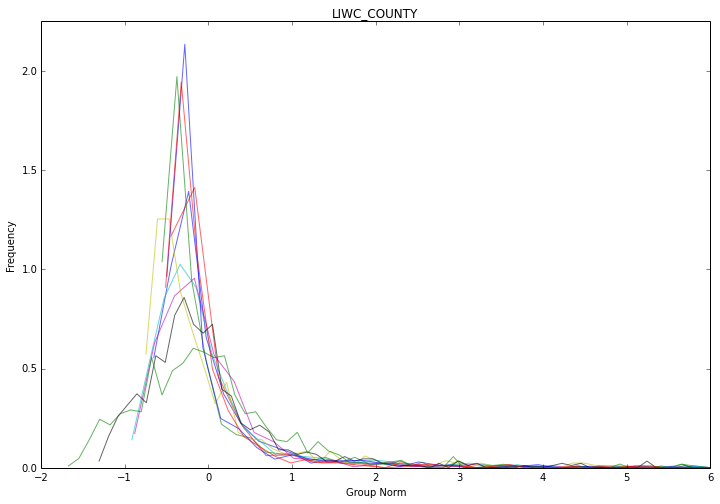


overall time: 1.0s -> query exec: 0.0s , fit: 0.0s
10196 data points for each feature
5000 random data points will be selected instead, if it is smaller
64 unique features
10 out of 64, PERCEPT-> query exec: 0.0s, fit: 0.0s

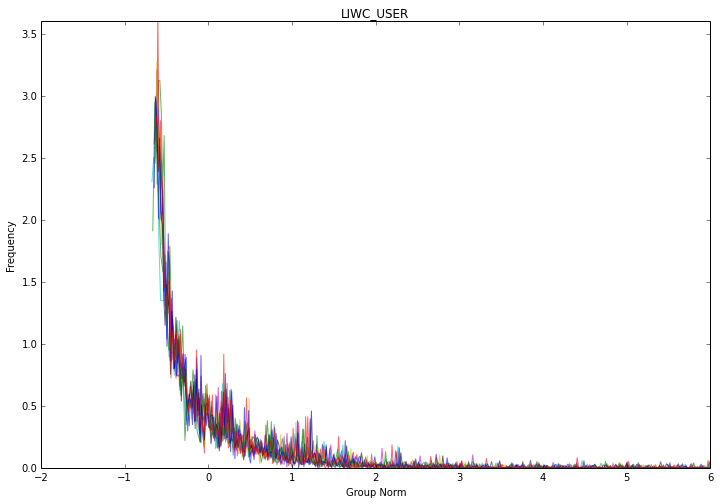


overall time: 2.0s -> query exec: 1.0s , fit: 0.0s
640485 data points for each feature
5000 random data points will be selected instead, if it is smaller
64 unique features
10 out of 64, CONJ-> query exec: 5.0s, fit: 0.0s

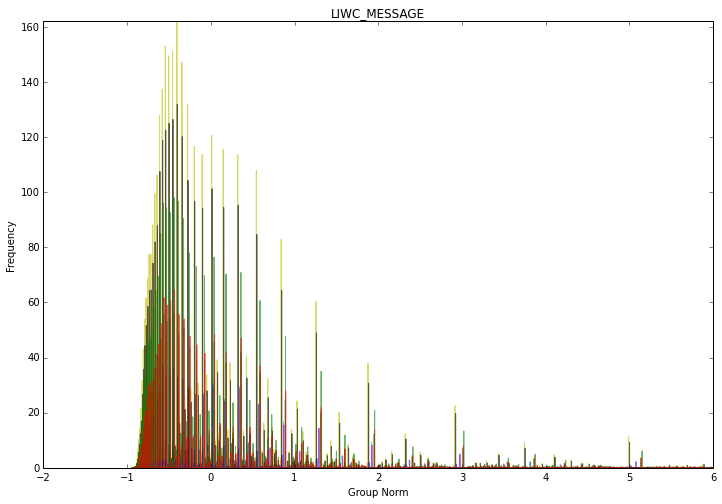


overall time: 36.0s -> query exec: 36.0s , fit: 0.0s
999 data points for each feature
5000 random data points will be selected instead, if it is smaller
64 unique features
10 out of 64, RELATIV-> query exec: 0.0s, fit: 0.0s

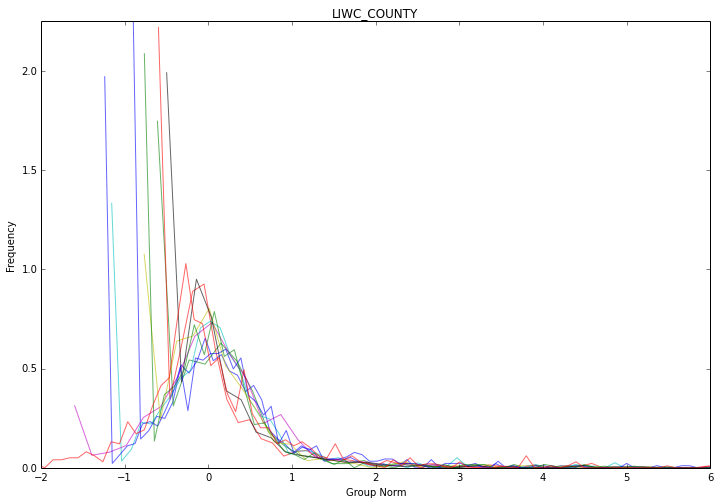


overall time: 0.0s -> query exec: 0.0s , fit: 0.0s
10196 data points for each feature
5000 random data points will be selected instead, if it is smaller
64 unique features
10 out of 64, ANGER-> query exec: 0.0s, fit: 0.0s

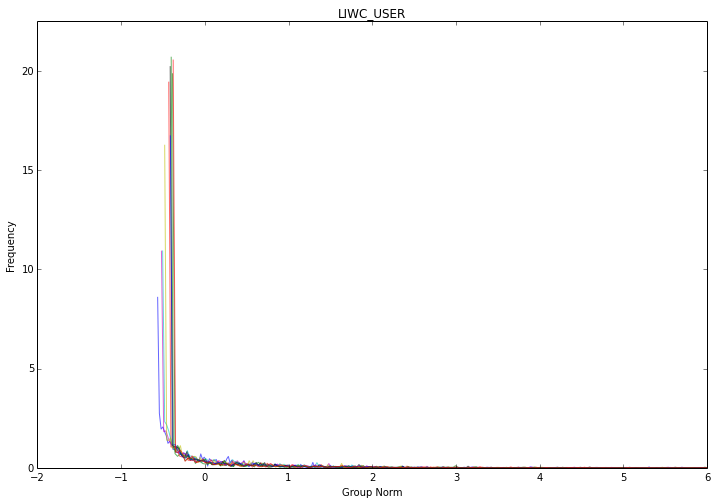


overall time: 1.0s -> query exec: 1.0s , fit: 0.0s
640485 data points for each feature
5000 random data points will be selected instead, if it is smaller
64 unique features
10 out of 64, CERTAIN-> query exec: 0.0s, fit: 0.0s

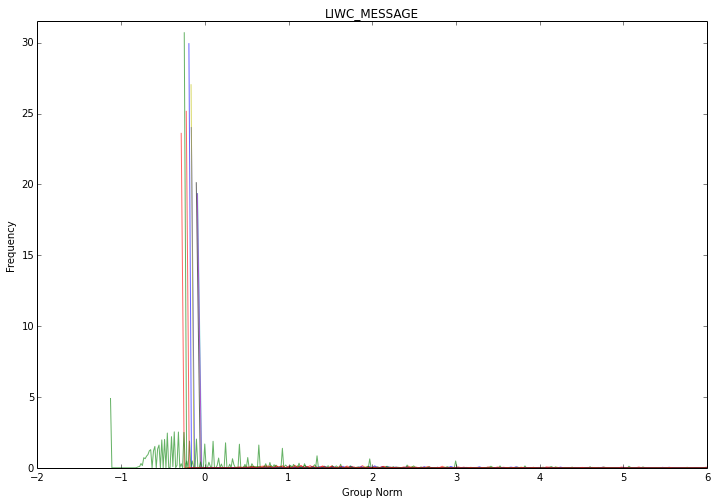


overall time: 2.0s -> query exec: 1.0s , fit: 0.0s


In [46]:
plot_features_pdf('feat$cat_LIWC2007$msgs_cnty_r1k$cnty$16to16', "LIWC_COUNTY", include_zero=False)
plot_features_pdf('feat$cat_LIWC2007$msgs_cnty_r1k$user_id$16to16', "LIWC_USER", include_zero=False)
plot_features_pdf('feat$cat_LIWC2007$msgs_cnty_r1k$message_id$16to16', "LIWC_MESSAGE", include_zero=False)

plot_features_pdf('feat$cat_LIWC2007$msgs_cnty_r1k$cnty$16to16', "LIWC_COUNTY", include_zero=True)
plot_features_pdf('feat$cat_LIWC2007$msgs_cnty_r1k$user_id$16to16', "LIWC_USER", include_zero=True)
plot_features_pdf('feat$cat_LIWC2007$msgs_cnty_r1k$message_id$16to16', "LIWC_MESSAGE", include_zero=True)